In [1]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20230112' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial']

# ASTROGET

This notebook demonstrates using the `astroget` package to get metadata and pixel data from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/).

### Table of contents
* [Goals & Summary](#goalssummary)
* [Imports and setup](#imports)
* [Data sets available in SPARCL](#datasets)
* [Get default field names](#defaultfieldnames)
* [Get all field names](#allfieldnames)
* [Data discovery I: using SPARCL's <tt>client.find()</tt> method](#datadiscoveryI)
* [Data discovery II: using Data Lab's <tt>sparcl.main_desi</tt> table](#datadiscoveryII)
* [Retrieve records by <tt>id</tt> using <tt>client.retrieve()</tt>](#retrieve)
* [Access fields in records](#access)
* [Convert retrieved output to Pandas DataFrame or Spectrum1D object](#convert)
* [Plot spectra](#plot)

<a class="anchor" id="goals"></a>
## Goals & Summary 
Demonstrate the use of the `astroget` package to get metadata and pixel data from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/). 
- Discovery: Search for matching metadata and return metadata records.
- Find images containing regions of sky (SIA)
- Retrieve images
  + Full FITS file
  + Single HDU of FITS file
  + Cutout of rectangular region of one HDU of a FITS file (as a new FITS file)


<a class="anchor" id="install"></a>
## Install the most recent version of the `astroget`:
*NOTE: After installing the most recent version, please restart your kernel.*

In [3]:
!pip install -U astroget


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


<a class="anchor" id="imports"></a>
## Imports and Setup

In [4]:
import astroget.client

# %matplotlib inline
%matplotlib widget
plt.rcParams['font.size'] = 14

/Users/alice.jacques/anaconda3/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/Users/alice.jacques/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
client = sparcl.client.CsDcClient()
client

(sparclclient:1.1, api:8.0, https://sparclstage.datalab.noirlab.edu/sparc, verbose=False, connect_timeout=1.1, read_timeout=5400)

import astroget.client<a class="anchor" id="datasets"></a>
## Data sets available in SPARCL
List all currently available data sets from the server/url associated with client

In [6]:
client.all_datasets

{'BOSS-DR16', 'DESI-EDR', 'SDSS-DR16'}

<a class="anchor" id="defaultfieldnames"></a>
## Get default field names
Gets fields tagged as 'default' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'default' fields across all datasets currently available in the SPARC database.

In [7]:
client.get_default_fields?

Signature: client.get_default_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'default' that are in DATASET_LIST.
These are the fields used for the DEFAULT value of the include
parameter of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get the default fields. Defaults to None, which
        will return the intersection of default fields in all
        data sets hosted on the SPARC database.

Returns:
    List of fields tagged as 'default' from DATASET_LIST.

Example:
    >>> client = sparcl.client.SparclClient()
    >>> client.get_default_fields()
File:      ~/anaconda3/lib/python3.8/site-packages/sparcl/client.py
Type:      method


In [8]:
client.get_default_fields(dataset_list=['DESI-EDR'])

['dec', 'flux', 'id', 'ra', 'specid', 'wavelength']

<a class="anchor" id="allfieldnames"></a>
## Get all field names
Gets fields tagged as 'all' that are common to all data sets in the `dataset_list` passed to the function. If `dataset_list` is None (the default), the function returns the intersection of 'all' fields across all datasets currently available in the SPARC database. 

In [9]:
client.get_all_fields?

Signature: client.get_all_fields(*, dataset_list=None)
Docstring:
Get fields tagged as 'all' that are in DATASET_LIST.
These are the fields used for the ALL value of the include parameter
of client.retrieve().

Args:
    dataset_list (:obj:`list`, optional): List of data sets from
        which to get all fields. Defaults to None, which
        will return the intersection of all fields in all
        data sets hosted on the SPARC database.

Returns:
    List of fields tagged as 'all' from DATASET_LIST.

Example:
    >>> client = sparcl.client.SparclClient()
    >>> client.get_all_fields()
File:      ~/anaconda3/lib/python3.8/site-packages/sparcl/client.py
Type:      method


In [10]:
print(sorted(client.get_all_fields(dataset_list=['DESI-EDR'])))

['data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'healpix', 'id', 'instrument', 'ivar', 'mask', 'model', 'program', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'specid', 'specprimary', 'spectype', 'survey', 'sv_primary', 'targetid', 'telescope', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']


<a class="anchor" id="datadiscoveryI"></a>
## Data discovery I: using SPARCL's `client.find()` method
The first way you can discover your data is by using SPARCL's `client.find()` method, which allows you to find records in the SPARCL database based on certain parameters passed to the function. Only Core fields may be in the `outfields` and `constraints` parameters. The descriptions for all fields, including Core fields, is located [here](http://sparclstage.datalab.noirlab.edu/sparc/sfc/). The SPARCL Core fields constraint types are:


| Field name       | Constraint type | Example |
|:----------------|:---------------|:-------|
| id               | List of values (but not<br>intended for data discovery) | ['00001658-460c-4da1-987d-e493d8c9b89b',<br>'000017b6-56a2-4f87-8828-3a3409ba1083']
| specid           | List of values | [6988698046080241664, 6971782884823945216]
| targetid         | List of values | [1237679502171374316, 1237678619584692841]
| data_release     | List of allowed values<br>from [SPARCL Categoricals](http://sparclstage.datalab.noirlab.edu/sparc/cats/) | ['BOSS-DR16', 'DESI-EDR', 'SDSS-DR16']
| datasetgroup     | List of allowed values<br>from [SPARCL Categoricals](hhttp://sparclstage.datalab.noirlab.edu/sparc/cats/) | ['DESI', 'SDSS_BOSS']
| ra               | Range of values (may not<br>"wrap" around RA=0) | [44.53, 47.96]
| dec              | Range of values | [2.03, 7.76]
| redshift         | Range of values | [0.5, 0.9]
| redshift_err     | Range of values | [0.000225, 0.000516]
| redshift_warning | List of values  | [0, 3, 5]
| spectype         | List of allowed values<br>from [SPARCL Categoricals](http://sparclstage.datalab.noirlab.edu/sparc/cats/) | ['GALAXY', 'STAR']
| instrument       | List of allowed values<br>from [SPARCL Categoricals](http://sparclstage.datalab.noirlab.edu/sparc/cats/) | ['BOSS', 'DESI', 'SDSS']
| telescope        | List of allowed values<br>from [SPARCL Categoricals](http://sparclstage.datalab.noirlab.edu/sparc/cats/) | ['kp4m', 'sloan25m']
| site             | List of allowed values<br>from [SPARCL Categoricals](http://sparclstage.datalab.noirlab.edu/sparc/cats/) |  ['apo', 'kpno']
| specprimary      | List of values (but typically<br>would only include 1 if<br>being used for data<br>discovery constraints) | [1]
| wavemin          | Range of values | [3607, 3608]
| wavemax          | Range of values | [10363, 10364]
| dateobs_center   | Range of values | ['2013-03-14T10:16:17Z',<br>'2014-05-24T12:10:00Z']
| exptime          | Range of values | [3603.46, 3810.12]
| updated          | Range of values | ['2022-08-20T21:37:50.636363Z',<br>'2022-09-20T20:00:00.000000Z']


In [11]:
client.find?

Signature: client.find(outfields=None, *, constraints={}, limit=500, sort=None)
Docstring:
Find records in the SPARC database.

Args:
    outfields (:obj:`list`, optional): List of fields to return.
        Only CORE fields may be passed to this parameter.
        Defaults to None, which will return only the id and _dr
        fields.

    constraints (:obj:`dict`, optional): Key-Value pairs of
        constraints to place on the record selection. The Key
        part of the Key-Value pair is the field name and the
        Value part of the Key-Value pair is a list of values.
        Defaults to no constraints. This will return all records in the
        database subject to restrictions imposed by the ``limit``
        parameter.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500.

    sort (:obj:`list`, optional): Comma separated list of fields
        to sort by. Defaults to None. (no sorting)

Returns:
    :class:`~sparcl.Results.Found`: 

#### Define the fields we want returned (`outfields`) and the constraints (`constraints`):

In [12]:
out = ['id', 'ra', 'dec', 'redshift', 'spectype', 'data_release', 'redshift_err']
cons = {'spectype': ['GALAXY'],
        'redshift': [0.5, 0.9],
        'data_release': ['BOSS-DR16', 'SDSS-DR16', 'DESI-EDR']}

#### Execute the `client.find()` method with our parameters:
The `limit` argument here is being used for demonstration purposes only, and simply returns only the first 20 results here.

In [13]:
found_I = client.find(outfields=out, constraints=cons, limit=20)
["%s, %s, %f, %f" % (f['data_release'],f['id'],f['ra'],f['redshift']) for f in found_I.records]

['DESI-EDR, 000001ce-1432-4e38-9609-2b579a01f079, 165.061429, 0.813519',
 'BOSS-DR16, 00000a7a-579e-4617-bde7-40cb06813278, 133.832300, 0.562171',
 'BOSS-DR16, 000025a4-c7b9-4729-afaf-e5b67076c4ec, 136.219720, 0.517059',
 'DESI-EDR, 000025d7-d443-47d4-8b86-96eb5a6ecc42, 186.170259, 0.558836',
 'BOSS-DR16, 0000369a-273f-4ffa-b700-61a986eafc74, 177.533290, 0.502516',
 'DESI-EDR, 00003a53-dba4-4e7e-ba20-33d1d0fa8cbc, 240.298043, 0.886934',
 'BOSS-DR16, 00003ab0-15d9-4b62-a187-08889be043a7, 4.177912, 0.885493',
 'BOSS-DR16, 00005446-0b24-438f-b11f-b967480aa12f, 342.749110, 0.888598',
 'BOSS-DR16, 00005687-1514-47c2-8395-42df66ed6894, 152.388040, 0.582597',
 'BOSS-DR16, 00006319-bf2e-4791-947f-49a3f18dac90, 162.858130, 0.592236',
 'BOSS-DR16, 00006ac2-23a2-4d1f-b595-73e04ac63158, 21.289818, 0.559281',
 'BOSS-DR16, 00006edb-7225-4e14-afcc-121d216556cf, 246.221190, 0.538009',
 'BOSS-DR16, 000070af-f9c3-4ccd-b9eb-4cf9bccb172a, 177.944580, 0.508008',
 'DESI-EDR, 00007875-1c56-4f84-9680-9acc886a

<a class="anchor" id="datadiscoveryII"></a>
## Data discovery II: using Data Lab's `sparcl.main_desi` table
The second way you can discover your data is by querying the `sparcl.main_desi` table hosted at Data Lab on db01 (temporary place and name until DESI is ready to go public). Once DESI is ready to go public, this table will be renamed to `sparcl.main` and copied to our Production servers.

In [14]:
qc.set_profile('db01')

In [15]:
qc.get_profile()

'db01'

#### Query this table for a few rows of data:

In [16]:
%%time
q = """SELECT 
            id, specid, ra, dec, redshift, spectype, data_release, redshift_err
        FROM 
            sparcl.main_desi
        WHERE 
            spectype='GALAXY'
            AND redshift>=0.5 AND redshift<=0.9
            AND (data_release='DESI-EDR' OR data_release='SDSS-DR16')
            AND random_id BETWEEN 25.1 AND 26.4
        LIMIT 20
    """
found_II = qc.query(sql=q, fmt='pandas')  # output as Pandas DataFrame
found_II

CPU times: user 37.3 ms, sys: 6.88 ms, total: 44.2 ms
Wall time: 278 ms


,id,specid,ra,dec,redshift,spectype,data_release,redshift_err
0,bff3b698-7fe7-4f8b-82db-2da926943718,3256236197621557248,181.019720,0.251678,0.533363,GALAXY,SDSS-DR16,0.000038
1,4cff768f-a28b-4860-a5d7-fd143a75c422,39633416345354557,189.750500,62.500957,0.618982,GALAXY,DESI-EDR,0.000084
2,7d0e1233-338d-4458-9266-404157f3027b,39627902957913055,211.128546,4.871387,0.847476,GALAXY,DESI-EDR,0.000108
3,0346aa84-5432-461b-bd5e-4f396e35d625,39628395465670984,193.071361,25.950393,0.826560,GALAXY,DESI-EDR,0.000035
4,4275d096-2490-4afb-84fa-54098c8f8900,616088504471912965,219.296593,-1.522164,0.653171,GALAXY,DESI-EDR,0.000062
5,ff594e5e-d15d-48e4-9fe0-28b5e0d78b7d,39628454563415544,193.457294,28.689220,0.734129,GALAXY,DESI-EDR,0.000082
6,32ad391b-5e7b-41c5-b1c1-68932357f0b1,39627763623135913,182.120423,-0.950399,0.538820,GALAXY,DESI-EDR,0.000110
7,7ecf8711-1bc8-449b-85e6-fd6238721fd9,39633425279222476,271.739360,63.160572,0.872827,GALAXY,DESI-EDR,0.000036
8,23075b53-bf8c-443f-bcb1-d41b9fa15452,39632945853498819,186.384933,33.136714,0.800302,GALAXY,DESI-EDR,0.000023
9,fff2c501-bb4f-4609-be96-6b5c724f081d,39627233710575456,85.338813,-23.384716,0.691024,GALAXY,DESI-EDR,0.000039


<a class="anchor" id="retrieve"></a>
## Retrieve records by `id` using `client.retrieve()`
In order to retrieve spectra records from SPARCL by `id`, pass the following to the `client.retrieve()` method:
```
uuid_list : List of IDs.
dataset_list : List of data sets to search for the IDs in (default: None).
include : List of field names to include in each record (default: 'DEFAULT').
```

**NOTE: A reasonable amount of records to request retrieval of is about 10,000. Exceeding this value may cause the retrieval to timeout or fail.**

In [17]:
client.retrieve?

Signature:
client.retrieve(
    uuid_list,
    *,
    svc='spectras',
    format='pkl',
    include='DEFAULT',
    dataset_list=None,
    limit=500,
    chunk=500,
    verbose=None,
)
Docstring:
Retrieve spectra records from the SPARC database by list of ids.

Args:
    uuid_list (:obj:`list`): List of ids.

    svc (:obj:`str`, optional): Defaults to 'spectras'.

    format (:obj:`str`, optional): Defaults to 'pkl'.

    include (:obj:`list`, optional): List of field names to include
        in each record. Defaults to 'DEFAULT', which will return
        the fields tagged as 'default'.

    dataset_list (:obj:`list`, optional): List of data sets from
        which to retrieve spectra data. Defaults to None, meaning all
        data sets hosted on the SPARC database.

    limit (:obj:`int`, optional): Maximum number of records to
        return. Defaults to 500.

    chunk (:obj:`int`, optional): Size of chunks to break list into.
        Defaults to 500.

    verbose (:obj:`bool`, op

#### Use the IDs from the output of using `client.find()` to retrieve records from SPARCL:
Note that `ids` in `found_I.ids` is a property name of the Found class. It is a list of records from all records, not a field name of a record.

In [18]:
# Define the fields to include in the retrieve function
inc = ['id', 'specid', 'data_release', 'redshift', 'flux', 'wavelength',
       'model', 'ivar', 'mask', 'spectype']

In [19]:
%%time
ids_I = found_I.ids
results_I = client.retrieve(uuid_list=ids_I,
                          include=inc,
                          dataset_list=['BOSS-DR16', 'SDSS-DR16', 'DESI-EDR'])
results_I.info

CPU times: user 65.6 ms, sys: 64.1 ms, total: 130 ms
Wall time: 1.62 s


{'status': {'success': True,
  'info': ["Successfully found 20 records in dr_list=['BOSS-DR16', 'SDSS-DR16', 'DESI-EDR']"],
  'warnings': []},
 'Count': 20}

#### Find IDs from SDSS-DR16 and BOSS-DR16, then retrieve AUX records

In [20]:
out = ['id']
cons = {'spectype': ['QSO'],
        'specprimary': [1],
        'data_release': ['BOSS-DR16', 'SDSS-DR16']}

In [21]:
found_III = client.find(outfields=out, constraints=cons, limit=20)

In [22]:
incl = ['id', 'specid', 'data_release', 'plate', 'fiberid', 'mjd', 'run2d']

In [23]:
%%time
ids_III = found_III.ids
results_III = client.retrieve(uuid_list=ids_III,
                          include=incl,
                          dataset_list=['BOSS-DR16', 'SDSS-DR16'])
results_III.info

CPU times: user 34.7 ms, sys: 6.59 ms, total: 41.3 ms
Wall time: 263 ms


{'status': {'success': True,
  'info': ["Successfully found 20 records in dr_list=['BOSS-DR16', 'SDSS-DR16']"],
  'warnings': []},
 'Count': 20}

In [24]:
# Access the first retrieved record
records_III = results_III.records[0]

specid = records_III.specid
data_release = records_III.data_release
plate = records_III.plate
fiberid = records_III.fiberid
mjd = records_III.mjd
run2d = records_III.run2d

print(f"For specid = {specid} from data_release = {data_release}\n"
      f"Plate: {plate}, FiberID: {fiberid}, MJD: {mjd}, Run2D: {run2d}")

For specid = 6976207868027752448 from data_release = BOSS-DR16
Plate: 6196, FiberID: 480, MJD: 56189, Run2D: v5_13_0


#### Use the specIDs from the `sparcl.main_desi` table to retrieve records from SPARCL:
We first need to convert the Pandas Series of specIDs into an int list to work with SPARCL. Then we can pass the int list to the `client.retrieve_by_specid()` method.

In [25]:
specids = [int(s) for s in found_II['specid']]

In [26]:
%%time
results_II = client.retrieve_by_specid(specid_list=specids,
                          include=inc,
                          dataset_list=['DESI-EDR', 'SDSS-DR16'])
results_II.info

CPU times: user 134 ms, sys: 92.5 ms, total: 227 ms
Wall time: 2.52 s


{'status': {'success': True,
  'info': ["Successfully found 21 records in dr_list=['DESI-EDR', 'SDSS-DR16']"],
  'warnings': []},
 'Count': 21}

<a class="anchor" id="access"></a>
## Access fields in records
You can access the fields from records by using dot notation and dictionary indexing.

#### Accessing a record from our example using `client.find()` and `client.retrieve()`:

In [27]:
records_I = results_I.records[0]

id_I = records_I.id
data_release_I = records_I.data_release
redshift_I = records_I.redshift
flux_I = records_I.flux
wavelength_I = records_I.wavelength
model_I = records_I.model
ivar_I = records_I.ivar
mask_I = records_I.mask
spectype_I = records_I.spectype

<a class="anchor" id="convert"></a>
## Convert retrieved output to Pandas DataFrame or Spectrum1D object

#### Pandas DataFrame:

In [28]:
df = pd.DataFrame([[r.data_release, r.id, r.redshift, r.wavelength, r.flux]
                    for r in results_I.records],
                  columns=['data_release', 'id', 'redshift', 'wavelength', 'flux'])
df

,data_release,id,redshift,wavelength,flux
0,DESI-EDR,000001ce-1432-4e38-9609-2b579a01f079,0.813519,"[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[1.0961802005767822, -1.6880725622177124, 2.30..."
1,BOSS-DR16,00000a7a-579e-4617-bde7-40cb06813278,0.562171,"[3555.4944085859292, 3556.3131856898544, 3557....","[3.6426377296447754, 3.642536163330078, 3.6424..."
2,BOSS-DR16,000025a4-c7b9-4729-afaf-e5b67076c4ec,0.517059,"[3568.617492834813, 3569.439291988468, 3570.26...","[-0.596808671951294, 0.030597688630223274, 2.3..."
3,DESI-EDR,000025d7-d443-47d4-8b86-96eb5a6ecc42,0.558836,"[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[2.4511337280273438, -2.0913825035095215, 0.15..."
4,BOSS-DR16,0000369a-273f-4ffa-b700-61a986eafc74,0.502516,"[3554.6758199906994, 3555.494408585933, 3556.3...","[-10.43215560913086, -10.43178939819336, -7.89..."
5,DESI-EDR,00003a53-dba4-4e7e-ba20-33d1d0fa8cbc,0.886934,"[3600.0, 3600.8, 3601.6000000000004, 3602.4000...","[-7.370975017547607, -4.113868713378906, -3.39..."
6,BOSS-DR16,00003ab0-15d9-4b62-a187-08889be043a7,0.885493,"[3590.0458899019936, 3590.872623694513, 3591.6...","[-76.72148895263672, -76.70281982421875, -76.6..."
7,BOSS-DR16,00005446-0b24-438f-b11f-b967480aa12f,0.888598,"[3576.844005764754, 3577.6676993611104, 3578.4...","[0.8816239833831787, 0.8817424178123474, 0.881..."
8,BOSS-DR16,00005687-1514-47c2-8395-42df66ed6894,0.582597,"[3572.7283815192886, 3573.5511273490297, 3574....","[-2.5826632976531982, -2.5840744972229004, -0...."
9,BOSS-DR16,00006319-bf2e-4791-947f-49a3f18dac90,0.592236,"[3553.857419860757, 3554.6758199906994, 3555.4...","[30.13748550415039, 7.0281453132629395, -25.78..."


#### Spectrum1D:
When applicable, the units for each field are documented on the [SPARCL webpage](http://sparclstage.datalab.noirlab.edu) by clicking the name of the data set

In [29]:
specs = [Spectrum1D(spectral_axis = r.wavelength*u.AA,
                    flux = np.array(r.flux)* 10**-17 * u.Unit('erg cm-2 s-1 AA-1'),
                    uncertainty = InverseVariance(np.array(r.ivar)),
                    redshift = r.redshift,
                    mask = r.mask)
        for r in results_I.records]
specs[0]

<Spectrum1D(flux=<Quantity [ 1.09618020e-17, -1.68807256e-17,  2.30594230e-17, ...,
            5.18360674e-18,  5.87683260e-18,  6.92537904e-18] erg / (Angstrom cm2 s)>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=159991.68640987598 km / s
      redshift=0.8135194222888051)
  [3600. , 3600.8, 3601.6, ..., 9822.4, 9823.2, 9824. ] Angstrom>, uncertainty=InverseVariance([  0.44933867,   0.56658721,   0.54383731, ...,
                  84.21394348, 120.00515747, 193.18800354]))>

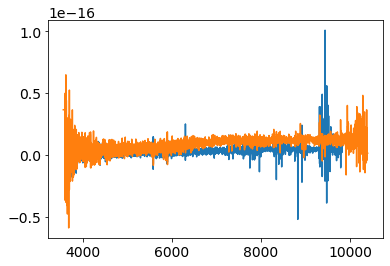

In [30]:
# Plot a couple
f, ax = plt.subplots()  
ax.step(specs[0].spectral_axis, specs[0].flux) 
ax.step(specs[1].spectral_axis, specs[1].flux)
plt.show()

<a class="anchor" id="plot"></a>
## Plot spectra

In [31]:
def plot_spec(index, results):
    """
    Pass an index value and the output from using client.retrieve()
    to plot the spectrum at the specified index.
    """
    
    record = results.records[index]

    id_ = record.id
    data_release = record.data_release
    flux = record.flux
    wavelength = record.wavelength
    model = record.model
    spectype = record.spectype

    plt.figure(figsize=(12,7))
    plt.title(f"Data Set = {data_release}, spectype = {spectype}, id = {id_}")
    plt.xlabel('$\lambda\ [\AA]$')
    plt.ylabel('$f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
    
    # Plot unsmoothed spectrum in grey
    plt.plot(wavelength, flux, color='k', alpha=0.2, label='Unsmoothed spectrum')
    
    # Overplot spectrum smoothed using a 1-D Gaussian Kernel in black
    plt.plot(wavelength, convolve(flux, Gaussian1DKernel(5)), color='k', label='Smoothed spectrum')
    
    # Overplot the model spectrum in red
    plt.plot(wavelength, model, color='r', label='Model spectrum')
    
    plt.legend()
    plt.show()

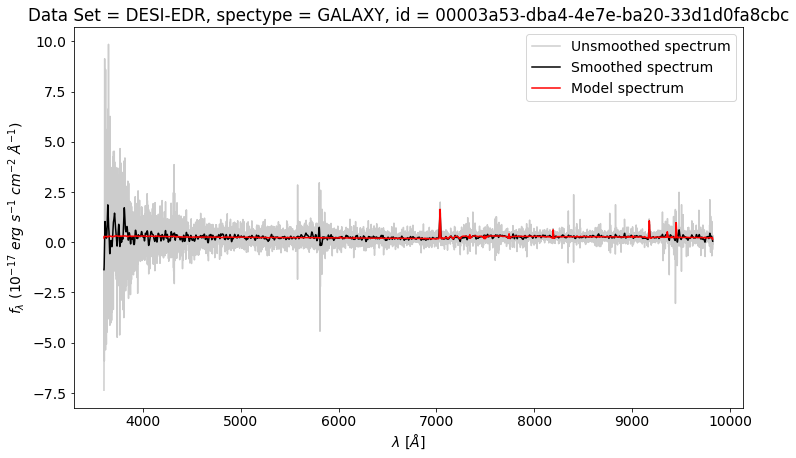

In [32]:
plot_spec(index=5, results=results_I)